In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data, train_test_normalise
from useful_fun import plot_sliding_window, number_outof_CI, split_dataframe_by_position


In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data) # y is unnormalised: good!

# get date for x-axis in plots: mm-yyyy
def get_xticks(df):
    dff = df.groupby(by='m-y').first()
    pos = dff.ids; pos = pos[1:]
    labels = dff.index; labels = labels[1:]
    return pos, labels

2022-08-13 11:30:30.254412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-13 11:30:30.836197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:60:00.0, compute capability: 7.5


# Sliding Window
### Simple one-latent function model with SVGP

        y = f(x) + e
        f = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

In [3]:
def optimise_model(model, x_train, y_train):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    epochs = 50
    for epoch in range(1, epochs + 1):
        optimisation_step()

Let's try first train on 10months predict on 2months

iterations to go through, plot:  116 69


2022-08-13 11:30:34.902860: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-13 11:30:39.712973: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7119b90


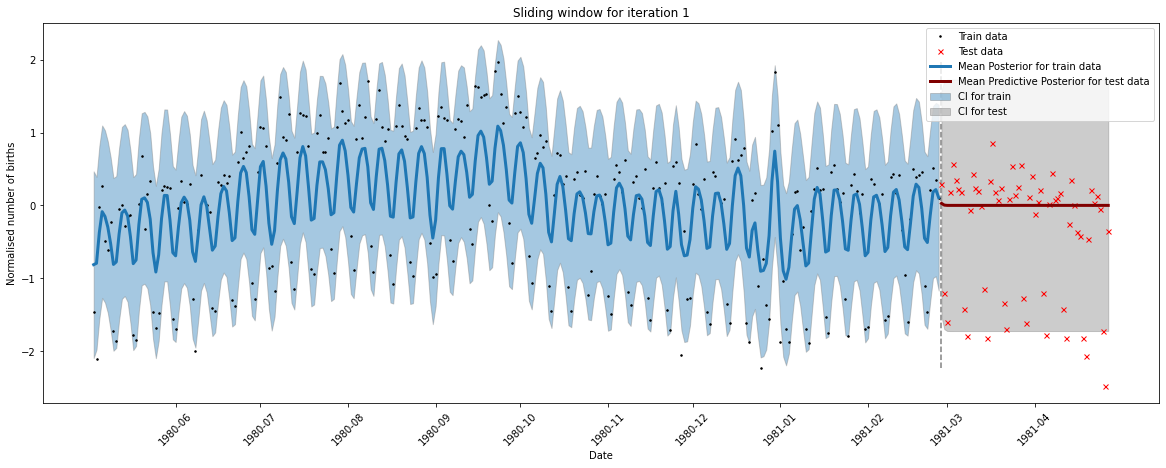

ELBO Avg:  -310.173689273988
Train Avg. MSE, MAE, points outside CI:  0.3946036741855029 0.527629367987339 11.206896551724139
Test Avg. MSE, MAE, points outside CI:  1.151671805847638 0.8793027863948685 6.379310344827586


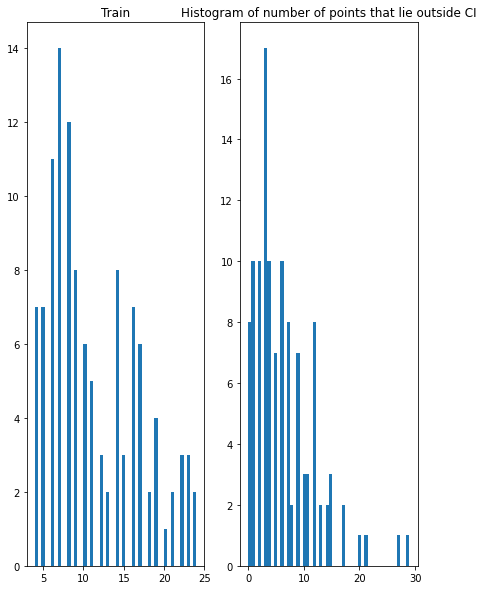

In [4]:
splits = 121 # two month split
split_dataframes = split_dataframe_by_position(data, splits)

# evaluation lists
ELBO_train = []
mse_train = []; mae_train = []; n_outof_CI_train = []
mse_test = [];  mae_test = [];  n_outof_CI_test = []

# window sizes
window_size = 5 # 5 for 10months
iterations = splits-window_size

# which iteration to plot
iteration_plot = np.random.randint(low=0, high=iterations)
print('iterations to go through, plot: ', iterations, iteration_plot)

for i in range(splits-window_size):
    # create new dataframe
    df = pd.DataFrame()

    # select data
    for df_ind in range(window_size):
        if df_ind == 0:
            df = split_dataframes[i]
        else :
            df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

    whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
    pos, labels = get_xticks(whole_data)

    # normalise & separate data
    df_train = df; df_test = split_dataframes[i+window_size]
    df_train, df_test = train_test_normalise(df_train, df_test)
    x_train, y_train = separate_data(df_train)
    x_test, y_test = separate_data(df_test)

    # number of inducing points
    M = int(0.7 * x_train.shape[0])
    
    # build model
    kernel = gpflow.kernels.RBF(lengthscales = 1, variance = 1)
    #Z = x_train.numpy().copy()
    Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

    # optimise
    optimise_model(model, x_train, y_train)

    # predict
    mean_train, var_train = model.predict_f(x_train)
    mean_test, var_test = model.predict_f(x_test)

    # evaluate
    ELBO_train.append(model.elbo((x_train,y_train)).numpy())
    mse_train.append(mean_squared_error(y_train, mean_train)); mae_train.append(mean_absolute_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
    mse_test.append(mean_squared_error(y_test, mean_test)); mae_test.append(mean_absolute_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))

    if i == iteration_plot:
        plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=1)
    

# Average evaluation metrics
print('ELBO Avg: ', np.mean(ELBO_train))
print('Train Avg. MSE, MAE, points outside CI: ', np.mean(mse_train), np.mean(mae_train), np.mean(n_outof_CI_train))
print('Test Avg. MSE, MAE, points outside CI: ', np.mean(mse_test), np.mean(mae_test), np.mean(n_outof_CI_test))

# histogram of CI
fig, ax = plt.subplots(1,2, figsize=(10,7))
ax[0].hist(n_outof_CI_train, bins=50)
ax[0].set_title('Train')
ax[1].hist(n_outof_CI_test, bins=50)
ax[1].set_title('Test')
plt.title('Histogram of number of points that lie outside CI')
plt.show()    

Try and fix overfitting.

First automate the process.

In [30]:
def slidingwindow_alg(splits, window_size, epochs=50):    
    split_dataframes = split_dataframe_by_position(data, splits)

    # evaluation lists
    ELBO_train = []
    mse_train = []; mae_train = []; n_outof_CI_train = []
    mse_test = [];  mae_test = [];  n_outof_CI_test = []

    # window sizes
    iterations = splits-window_size

    # which iteration to plot
    iteration_plot = np.random.randint(low=0, high=iterations)
    print('iterations to go through, plot: ', iterations, iteration_plot)

    for i in range(splits-window_size):
        # create new dataframe
        df = pd.DataFrame()

        # select data
        for df_ind in range(window_size):
            if df_ind == 0:
                df = split_dataframes[i]
            else :
                df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

        whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
        pos, labels = get_xticks(whole_data)

        # normalise & separate data
        df_train = df; df_test = split_dataframes[i+window_size]
        df_train, df_test = train_test_normalise(df_train, df_test)
        x_train, y_train = separate_data(df_train)
        x_test, y_test = separate_data(df_test)

        # number of inducing points
        M = int(0.7 * x_train.shape[0])
        
        # build model
        kernel = gpflow.kernels.RBF(lengthscales = 1, variance = 1)
        #Z = x_train.numpy().copy()
        Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
        model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
        set_trainable(model.likelihood.variance, False)
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

        # optimise/train step
        train_data = (x_train, y_train)
        loss_fn = model.training_loss_closure(train_data) 

        gpflow.utilities.set_trainable(model.q_mu, False)
        gpflow.utilities.set_trainable(model.q_sqrt, False)

        variational_vars = [(model.q_mu, model.q_sqrt)]
        natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
        adam_vars = model.trainable_variables
        adam_opt = tf.optimizers.Adam(0.01)

        @tf.function
        def optimisation_step():
            natgrad_opt.minimize(loss_fn, variational_vars)
            adam_opt.minimize(loss_fn, adam_vars)

        for epoch in range(1, epochs + 1):
            optimisation_step()

        # predict
        mean_train, var_train = model.predict_f(x_train)
        mean_test, var_test = model.predict_f(x_test)

        # evaluate
        ELBO_train.append(model.elbo((x_train,y_train)).numpy())
        mse_train.append(mean_squared_error(y_train, mean_train)); mae_train.append(mean_absolute_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
        mse_test.append(mean_squared_error(y_test, mean_test)); mae_test.append(mean_absolute_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))

        if i == iteration_plot:
            plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=1)
        

    # Average evaluation metrics
    print('ELBO Avg: ', np.mean(ELBO_train))
    print('Train Avg. MSE, MAE, points outside CI: ', np.mean(mse_train), np.mean(mae_train), np.mean(n_outof_CI_train))
    print('Test Avg. MSE, MAE, points outside CI: ', np.mean(mse_test), np.mean(mae_test), np.mean(n_outof_CI_test))

    # histogram of CI
    fig, ax = plt.subplots(1,2)
    ax[0].hist(n_outof_CI_train, bins=50)
    ax[0].set_title('Train')
    ax[1].hist(n_outof_CI_test, bins=50)
    ax[1].set_title('Test')
    plt.title('Histogram of number of points that lie outside CI')
    plt.show()

    return print_summary(model, fmt='notebook')

iterations to go through, plot:  116 97


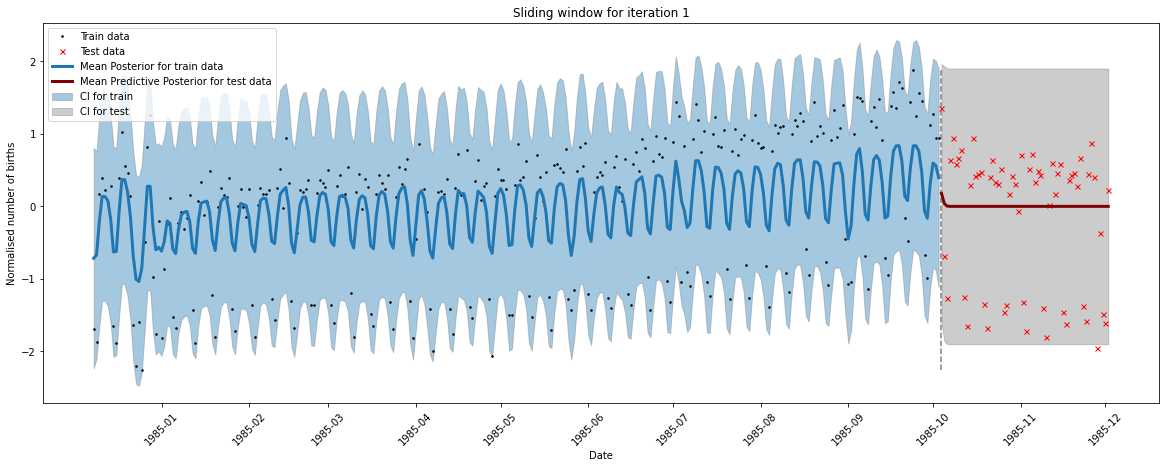

ELBO Avg:  -319.97919517935514
Train Avg. MSE, MAE, points outside CI:  0.42700464048252207 0.5477029363558156 2.6982758620689653
Test Avg. MSE, MAE, points outside CI:  1.1519835527533258 0.8793622055361607 3.4913793103448274


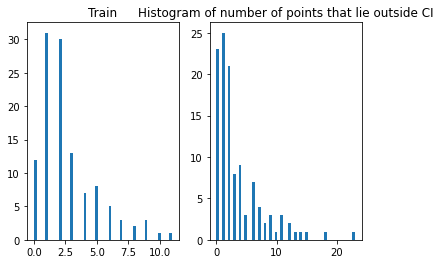

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.9411006733599463
SVGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,1.0647071975525706
SVGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(210, 1)",float64,[[6901.08036126...
SVGP.q_mu,Parameter,Identity,,False,"(210, 1)",float64,[[0.25853244...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 210, 210)",float64,"[[[7.90707477e-01, 0.00000000e+00, 0.00000000e+00..."


In [31]:
# less epochs
slidingwindow_alg(121, 5, epochs=10)

Train on 2yrs predict on 4months

iterations to go through, plot:  54 27


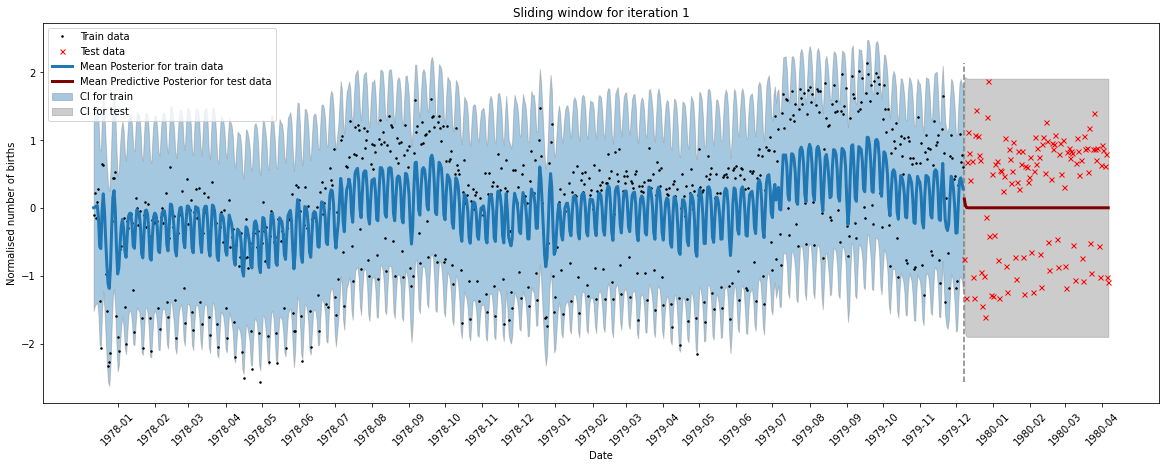

ELBO Avg:  -771.7236845954226
Train Avg. MSE, MAE, points outside CI:  0.41671399189277586 0.5396831509967839 5.407407407407407
Test Avg. MSE, MAE, points outside CI:  1.1613619692914916 0.91178068092541 6.555555555555555


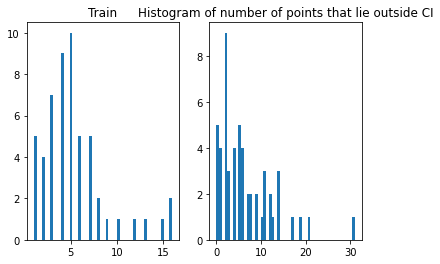

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.9411206032214807
SVGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,1.0646643101273465
SVGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(508, 1)",float64,[[6414.09780554...
SVGP.q_mu,Parameter,Identity,,False,"(508, 1)",float64,[[3.67493400e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 508, 508)",float64,"[[[7.90589707e-001, 0.00000000e+000, 0.00000000e+000..."


In [11]:
slidingwindow_alg(60, 6, epochs=10)

iterations to go through, plot:  54 24


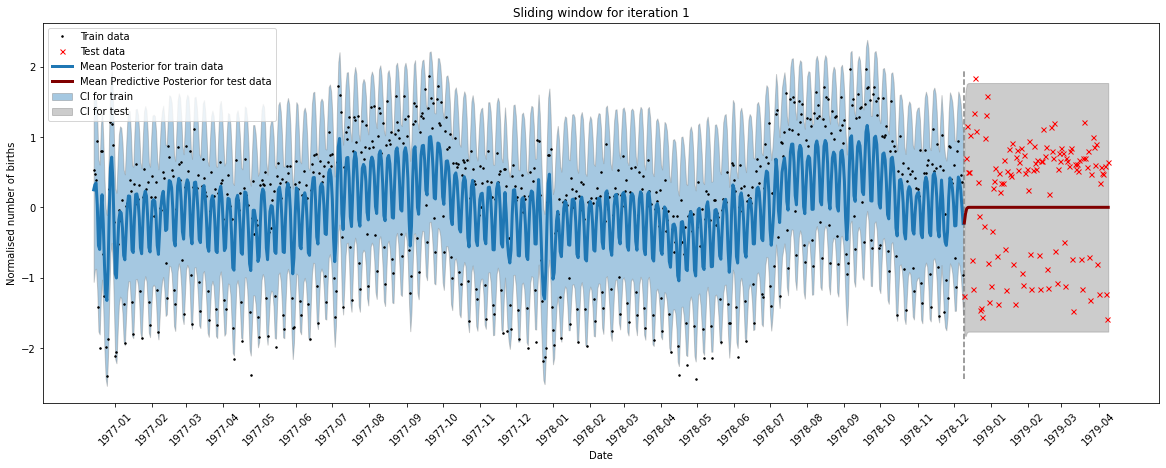

ELBO Avg:  -750.0841977371002
Train Avg. MSE, MAE, points outside CI:  0.36932484021732415 0.5095704526100198 16.962962962962962
Test Avg. MSE, MAE, points outside CI:  1.1609067458951121 0.9115589906852232 10.37037037037037


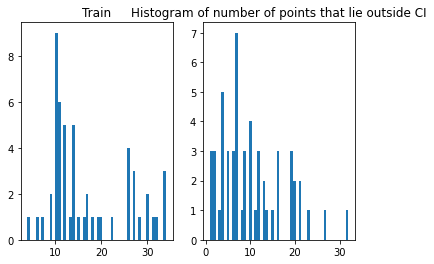

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.811485928241236
SVGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,1.2300251505955773
SVGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(508, 1)",float64,[[6414.06203513...
SVGP.q_mu,Parameter,Identity,,False,"(508, 1)",float64,[[0.46277414...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 508, 508)",float64,"[[[7.33054369e-001, 0.00000000e+000, 0.00000000e+000..."


In [12]:
slidingwindow_alg(60, 6, epochs=40)

/home/cn321/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

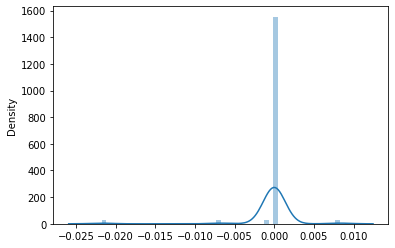

In [29]:
mean_test = np.reshape(mean_test, (1,60));
sns.distplot(mean_test)

Try train on 11 months predict on 1month

iterations to go through, plot:  232 228


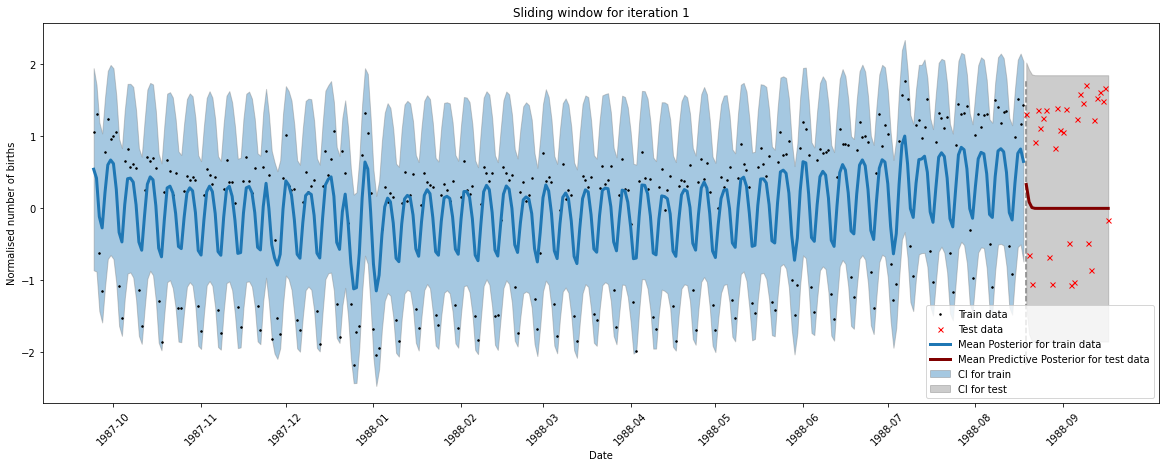

ELBO Avg:  -344.37815596578895
Train Avg. MSE, MAE, points outside CI:  0.37142216447172793 0.511015979240574 3.9698275862068964
Test Avg. MSE, MAE, points outside CI:  1.1061848966609706 0.8676663481192727 1.8448275862068966


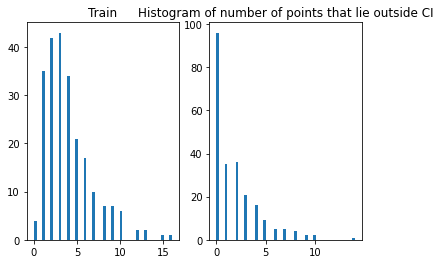

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.8917176828004669
SVGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,1.1302153999242073
SVGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(230, 1)",float64,[[6931.02017487...
SVGP.q_mu,Parameter,Identity,,False,"(230, 1)",float64,[[-3.70973840e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 230, 230)",float64,"[[[7.50727560e-01, 0.00000000e+00, 0.00000000e+00..."


: 

In [32]:
slidingwindow_alg(243, 11, epochs=20)